In [1]:
# Import dependencies
import requests
import json
import pandas as pd
from dotenv import load_dotenv, find_dotenv
import os
import time

# Load API Key
load_dotenv(find_dotenv('api.env')) # api.env not included in github. Please make separate env file.
api_key = os.getenv("POLYGON_KEY")

base_url = "https://api.polygon.io"
stocksTicker = f"SPY" # SPY = S&P 500 <-- Change this for different stock

multiplier = 5
timespan = 'minute' # multiplier + timespan = 5 minutes
t_from = '2024-03-18'
t_to = '2024-03-22'

query_url = f"{base_url}/v2/aggs/ticker/{stocksTicker}/range/{multiplier}/{timespan}/{t_from}/{t_to}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
# Get the response
response = requests.get(query_url)

# Retrieve reviews
reviews = response.json()

# Convert JSON to Pandas Dataframe
df = pd.json_normalize(reviews["results"])
df = df.rename(columns={'v':'Volume', 'vw':'Volume Weighted', 'o':'Open Price', 'c':'Close Price', 'h':'Highest Price', 'l':'Lowest Price', 't':'Timestamp', 'n':'Number of Transaction'})
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
df['Stock Name'] = stocksTicker


In [2]:
df

,Volume,Volume Weighted,Open Price,Close Price,Highest Price,Lowest Price,Timestamp,Number of Transaction,Stock Name
0,2857.0,511.2192,511.41,511.36,511.41,511.00,2024-03-18 08:00:00,65,SPY
1,1772.0,511.2107,511.31,511.22,511.31,511.16,2024-03-18 08:05:00,36,SPY
2,504.0,511.2886,511.30,511.28,511.30,511.28,2024-03-18 08:10:00,3,SPY
3,203.0,511.2706,511.27,511.27,511.27,511.27,2024-03-18 08:15:00,3,SPY
4,106.0,511.1701,511.17,511.17,511.17,511.17,2024-03-18 08:20:00,3,SPY
...,...,...,...,...,...,...,...,...,...
925,143.0,520.8990,520.89,520.89,520.89,520.89,2024-03-22 23:35:00,12,SPY
926,3040.0,520.8529,520.87,520.85,520.87,520.83,2024-03-22 23:40:00,33,SPY
927,2057.0,520.8294,520.88,520.80,520.89,520.80,2024-03-22 23:45:00,52,SPY
928,236.0,520.8500,520.85,520.85,520.85,520.85,2024-03-22 23:50:00,14,SPY


<Axes: xlabel='Timestamp'>

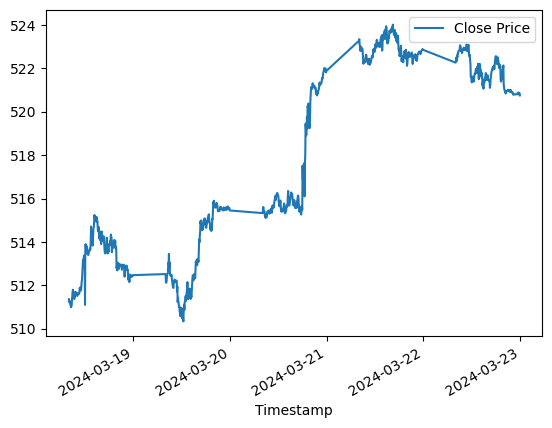

In [3]:
df.plot(kind='line',x='Timestamp', y='Close Price')
# Straight lines = weekends

In [4]:
#Save data to CSV
df.to_csv('../Data/spy-agg-03-18-03-22.csv', date_format='%Y-%m-%d %H:%M:%S', index=False)
# -----------------^^^ Change this to stock you chose

In [5]:
# Test CSV Import

df = pd.read_csv('../Data/spy-agg-03-18-03-22.csv', parse_dates=['Timestamp'])
# ------------------------^^^ Change this to stock you chose
df

,Volume,Volume Weighted,Open Price,Close Price,Highest Price,Lowest Price,Timestamp,Number of Transaction,Stock Name
0,2857.0,511.2192,511.41,511.36,511.41,511.00,2024-03-18 08:00:00,65,SPY
1,1772.0,511.2107,511.31,511.22,511.31,511.16,2024-03-18 08:05:00,36,SPY
2,504.0,511.2886,511.30,511.28,511.30,511.28,2024-03-18 08:10:00,3,SPY
3,203.0,511.2706,511.27,511.27,511.27,511.27,2024-03-18 08:15:00,3,SPY
4,106.0,511.1701,511.17,511.17,511.17,511.17,2024-03-18 08:20:00,3,SPY
...,...,...,...,...,...,...,...,...,...
925,143.0,520.8990,520.89,520.89,520.89,520.89,2024-03-22 23:35:00,12,SPY
926,3040.0,520.8529,520.87,520.85,520.87,520.83,2024-03-22 23:40:00,33,SPY
927,2057.0,520.8294,520.88,520.80,520.89,520.80,2024-03-22 23:45:00,52,SPY
928,236.0,520.8500,520.85,520.85,520.85,520.85,2024-03-22 23:50:00,14,SPY


In [6]:
# Analysis - Checking Max values
print(f"Max values for Volume: {df['Volume'].max()}")
print(f"Max values for Volume Weighted: {df['Volume Weighted'].max()}")
print(f"Max values for Open Price: {df['Open Price'].max()}")
print(f"Max values for Close Price: {df['Close Price'].max()}")
print(f"Max values for Highest Price: {df['Highest Price'].max()}")
print(f"Max values for Lowest Price: {df['Lowest Price'].max()}")
print(f"Max values for Number of Transaction: {df['Number of Transaction'].max()}")

# Looking at the result, standardizing of data will be needed!

Max values for Volume: 10364121.0
Max values for Volume Weighted: 523.9702
Max values for Open Price: 524.0
Max values for Close Price: 524.01
Max values for Highest Price: 524.11
Max values for Lowest Price: 523.81
Max values for Number of Transaction: 42817
